# Barrier Options Demo

*This notebook demonstrates continuous monitoring barrier pricing with Brownian bridge, digital options in BSM with dividend yield, and simple validations.*

**You will see**
* Up and down barriers priced by Monte Carlo with Brownian bridge
* In-out parity checks vs vanilla BSM
* Convergence with time steps
* Digitals sanity checks
* Plots and small experiments


In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os


# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

from src.barriers import (
    barrier_price_mc,
    MCConfig,
    digital_cash_bsm,
    digital_asset_bsm,
)
from src.black_scholes import black_scholes_price

np.set_printoptions(precision=6, suppress=True)


## 1) Parameters

*We set a base scenario and compute vanilla BSM prices for reference.*


In [6]:
S0 = 100.0
K  = 100.0
r  = 0.01
q  = 0.00
sigma = 0.20
T  = 0.75

cfg_fast = MCConfig(n_paths=80_000, n_steps=252, seed=42, antithetic=True)
cfg_accurate = MCConfig(n_paths=300_000, n_steps=365, seed=42, antithetic=True)

vanilla_call = black_scholes_price(S0, K, T, r, sigma, option_type="call", q=q)
vanilla_put  = black_scholes_price(S0, K, T, r, sigma, option_type="put",  q=q)

print(f"Vanilla call: {vanilla_call:.6f}")
print(f"Vanilla put : {vanilla_put:.6f}")


Vanilla call: 7.255498
Vanilla put : 6.508304


## 2) Up-and-out and Up-and-in calls

*Out should be below vanilla. In should be vanilla minus out.*


In [4]:
H_up = 120.0

p_uo_call = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                             option="call", barrier="up-and-out",
                             cfg=cfg_fast)
p_ui_call = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                             option="call", barrier="up-and-in",
                             cfg=cfg_fast)

print(f"Up-and-out call  : {p_uo_call:.6f}")
print(f"Up-and-in  call  : {p_ui_call:.6f}")
print(f"Sum in+out       : {p_uo_call + p_ui_call:.6f}  vs vanilla {vanilla_call:.6f}")


Up-and-out call  : 2.066903
Up-and-in  call  : 5.188596
Sum in+out       : 7.255498  vs vanilla 7.255498


## 3) Down-and-out and Down-and-in puts

*Same parity for puts with a down barrier.*


In [ ]:
H_dn = 80.0

p_do_put = barrier_price_mc(S0, K, H_dn, T, r, q, sigma,
                            option="put", barrier="down-and-out",
                            cfg=cfg_fast)
p_di_put = barrier_price_mc(S0, K, H_dn, T, r, q, sigma,
                            option="put", barrier="down-and-in",
                            cfg=cfg_fast)

print(f"Down-and-out put : {p_do_put:.6f}")
print(f"Down-and-in  put : {p_di_put:.6f}")
print(f"Sum in+out       : {p_do_put + p_di_put:.6f}  vs vanilla {vanilla_put:.6f}")


Down-and-out put : 3.018635
Down-and-in  put : 3.489669
Sum in+out       : 6.508304  vs vanilla 6.508304


## 4) Immediate knock-out sanity

*If S0 is on the wrong side of the barrier at t = 0, an out option should be near zero unless a rebate applies.*


In [ ]:
price_uo_immediate = barrier_price_mc(105.0, K, 100.0, T, r, q, sigma,
                                      option="call", barrier="up-and-out",
                                      cfg=cfg_fast)
print(f"Immediate KO (up-and-out, S0>=H): {price_uo_immediate:.12f}")


Immediate KO (up-and-out, S0>=H): 0.000000000000


## 5) Rebate effect

*Adding a rebate increases the knock-out price. Compare KO with and without a cash rebate.*



In [14]:
rebate0 = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                           option="call", barrier="up-and-out",
                           rebate=0.0, cfg=cfg_fast)
rebate5 = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                           option="call", barrier="up-and-out",
                           rebate=5.0, cfg=cfg_fast)

print(f"KO with rebate 0: {rebate0:.6f}")
print(f"KO with rebate 5: {rebate5:.6f}  (should be larger)")


KO with rebate 0: 2.066903
KO with rebate 5: 7.046601  (should be larger)


## 6) Convergence with time steps

*Barrier pricing is sensitive to time discretization. Brownian bridge reduces bias, but watch convergence as steps increase.*


steps= 64  price=2.069619
steps=126  price=2.055439
steps=252  price=2.081934
steps=504  price=2.068075


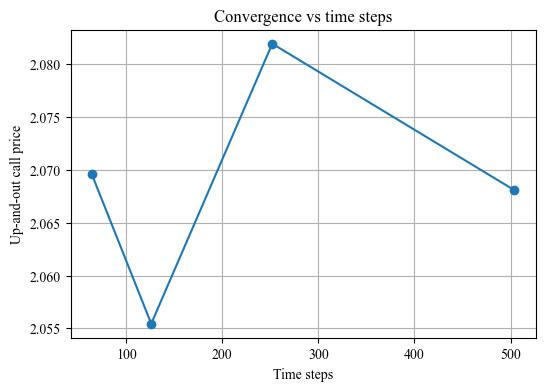

In [15]:
steps_list = [64, 126, 252, 504]
prices = []

for m in steps_list:
    cfg_m = MCConfig(n_paths=120_000, n_steps=m, seed=99, antithetic=True)
    p = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                         option="call", barrier="up-and-out",
                         cfg=cfg_m)
    prices.append(p)

for m, p in zip(steps_list, prices):
    print(f"steps={m:3d}  price={p:.6f}")

plt.figure(figsize=(6,4))
plt.plot(steps_list, prices, marker="o")
plt.xlabel("Time steps")
plt.ylabel("Up-and-out call price")
plt.title("Convergence vs time steps")
plt.grid(True)
plt.show()


## 7) Digitals in BSM with q

*Cash-or-nothing and asset-or-nothing digitals, plus simple bounds and monotonicity checks.*


In [16]:
cash_call = digital_cash_bsm(S0, K, T, r, sigma, q=q, option="call", cash=1.0)
cash_put  = digital_cash_bsm(S0, K, T, r, sigma, q=q, option="put",  cash=1.0)
asset_call = digital_asset_bsm(S0, K, T, r, sigma, q=q, option="call")
asset_put  = digital_asset_bsm(S0, K, T, r, sigma, q=q, option="put")

print(f"Cash digital call : {cash_call:.6f}")
print(f"Cash digital put  : {cash_put:.6f}")
print(f"Asset digital call: {asset_call:.6f}")
print(f"Asset digital put : {asset_put:.6f}")

# Monotonicity in strike for cash digital
cash_call_K_up = digital_cash_bsm(S0, K+1.0, T, r, sigma, q=q, option="call", cash=1.0)
cash_put_K_up  = digital_cash_bsm(S0, K+1.0, T, r, sigma, q=q, option="put",  cash=1.0)
print(f"Call cash digital decreases with K? {cash_call_K_up <= cash_call}")
print(f"Put  cash digital increases with K? {cash_put_K_up  >= cash_put }")


Cash digital call : 0.479124
Cash digital put  : 0.513404
Asset digital call: 55.167877
Asset digital put : 44.832123
Call cash digital decreases with K? True
Put  cash digital increases with K? True


## 8) Barrier sweep

*Price a small grid of up barriers for quick intuition.*

* Up-and-out call should increase as the barrier moves farther above spot.
* Up-and-in call should decrease correspondingly.
* Their sum should match the vanilla call at every barrier.


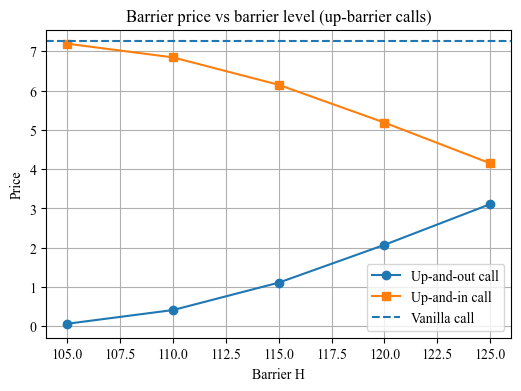

In [22]:
H_levels = np.array([105.0, 110.0, 115.0, 120.0, 125.0])
uo_prices, ui_prices = [], []

cfg_grid = MCConfig(n_paths=120_000, n_steps=252, seed=777, antithetic=True)

for H in H_levels:
    uo = barrier_price_mc(S0, K, H, T, r, q, sigma,
                          option="call", barrier="up-and-out",
                          cfg=cfg_grid)
    ui = barrier_price_mc(S0, K, H, T, r, q, sigma,
                          option="call", barrier="up-and-in",
                          cfg=cfg_grid)
    uo_prices.append(uo)
    ui_prices.append(ui)

uo_prices = np.array(uo_prices)
ui_prices = np.array(ui_prices)

plt.figure(figsize=(6,4))
plt.plot(H_levels, uo_prices, marker="o", label="Up-and-out call")
plt.plot(H_levels, ui_prices, marker="s", label="Up-and-in call")
plt.axhline(vanilla_call, linestyle="--", label="Vanilla call")
plt.xlabel("Barrier H")
plt.ylabel("Price")
plt.title("Barrier price vs barrier level (up-barrier calls)")
plt.grid(True)
plt.legend()
plt.show()


## 9) Higher accuracy run

*For tighter parity and smoother estimates, increase both paths and steps.*


In [23]:
p_uo_call_hi = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                                option="call", barrier="up-and-out",
                                cfg=cfg_accurate)
p_ui_call_hi = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                                option="call", barrier="up-and-in",
                                cfg=cfg_accurate)

print(f"[Accurate] UO call: {p_uo_call_hi:.6f}")
print(f"[Accurate] UI call: {p_ui_call_hi:.6f}")
print(f"[Accurate] Sum    : {p_uo_call_hi + p_ui_call_hi:.6f} vs vanilla {vanilla_call:.6f}")


[Accurate] UO call: 2.072870
[Accurate] UI call: 5.182629
[Accurate] Sum    : 7.255498 vs vanilla 7.255498


## 10) Down-barrier puts sweep

*Down-and-out put should increase as the barrier moves farther below spot (harder to knock out).  
Down-and-in put should decrease as the barrier moves farther away (harder to trigger).  
Their sum should match the vanilla put at every barrier level.*


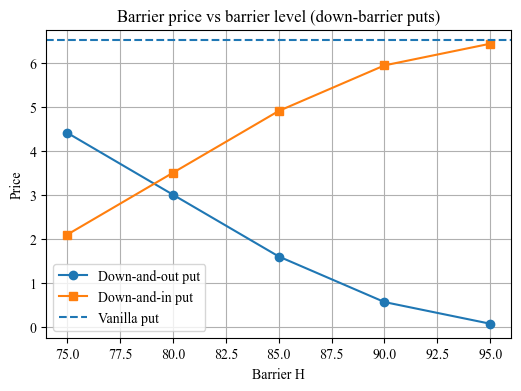

H    in+out    vanilla
95.0  6.508304  6.508304
90.0  6.508304  6.508304
85.0  6.508304  6.508304
80.0  6.508304  6.508304
75.0  6.508304  6.508304


In [24]:
# Down-barrier put sweep
H_levels_dn = np.array([95.0, 90.0, 85.0, 80.0, 75.0])
do_prices, di_prices = [], []

cfg_grid_dn = MCConfig(n_paths=120_000, n_steps=252, seed=123, antithetic=True)

for H in H_levels_dn:
    do = barrier_price_mc(S0, K, H, T, r, q, sigma,
                          option="put", barrier="down-and-out",
                          cfg=cfg_grid_dn)
    di = barrier_price_mc(S0, K, H, T, r, q, sigma,
                          option="put", barrier="down-and-in",
                          cfg=cfg_grid_dn)
    do_prices.append(do)
    di_prices.append(di)

do_prices = np.array(do_prices)
di_prices = np.array(di_prices)

plt.figure(figsize=(6,4))
plt.plot(H_levels_dn, do_prices, marker="o", label="Down-and-out put")
plt.plot(H_levels_dn, di_prices, marker="s", label="Down-and-in put")
plt.axhline(vanilla_put, linestyle="--", label="Vanilla put")
plt.xlabel("Barrier H")
plt.ylabel("Price")
plt.title("Barrier price vs barrier level (down-barrier puts)")
plt.grid(True)
plt.legend()
plt.show()

# Optional parity printout
print("H    in+out    vanilla")
for H, do, di in zip(H_levels_dn, do_prices, di_prices):
    print(f"{H:4.1f} {do+di:9.6f} {vanilla_put:9.6f}")


## 10) Barrier digitals vs analytical digitals

We verify classic identities in Black–Scholes:

* Cash digital call:  *e^{-rT} N(d2) = −∂C/∂K*  
* Cash digital put:   *e^{-rT} N(−d2) =  ∂P/∂K*  
* Asset digital call: *S e^{-qT} N(d1) = S · ∂C/∂S*  
* Asset digital put:  *S e^{-qT} N(−d1) = −S · ∂P/∂S*

We compare our digital formulas with central differences on vanilla prices.


In [25]:
# Finite difference helpers for K and S derivatives
def d_price_dK(option_type, K, h=1e-3):
    p_plus  = black_scholes_price(S0, K + h, T, r, sigma, option_type=option_type, q=q)
    p_minus = black_scholes_price(S0, K - h, T, r, sigma, option_type=option_type, q=q)
    return (p_plus - p_minus) / (2.0 * h)

def d_price_dS(option_type, S, h=1e-3):
    p_plus  = black_scholes_price(S + h, K, T, r, sigma, option_type=option_type, q=q)
    p_minus = black_scholes_price(S - h, K, T, r, sigma, option_type=option_type, q=q)
    return (p_plus - p_minus) / (2.0 * h)

# Step sizes relative to scale
hK = 1e-3 * max(1.0, K)
hS = 1e-3 * max(1.0, S0)

# Cash digitals vs strike derivatives
cash_call = digital_cash_bsm(S0, K, T, r, sigma, q=q, option="call", cash=1.0)
cash_put  = digital_cash_bsm(S0, K, T, r, sigma, q=q, option="put",  cash=1.0)
dCdK = d_price_dK("call", K, h=hK)
dPdK = d_price_dK("put",  K, h=hK)
print("Cash digital identities:")
print(f"call:  cash={cash_call:.8f}  vs  -dC/dK={-dCdK:.8f}  diff={abs(cash_call + dCdK):.3e}")
print(f"put :  cash={cash_put :.8f}  vs   dP/dK={ dPdK:.8f}  diff={abs(cash_put  - dPdK):.3e}")

# Asset digitals vs S derivatives
asset_call = digital_asset_bsm(S0, K, T, r, sigma, q=q, option="call")
asset_put  = digital_asset_bsm(S0, K, T, r, sigma, q=q, option="put")
dCdS = d_price_dS("call", S0, h=hS)
dPdS = d_price_dS("put",  S0, h=hS)
print("\nAsset digital identities:")
print(f"call:  asset={asset_call:.8f}  vs  S*dC/dS={S0*dCdS:.8f}  diff={abs(asset_call - S0*dCdS):.3e}")
print(f"put :  asset={asset_put :.8f}  vs -S*dP/dS={-S0*dPdS:.8f}  diff={abs(asset_put  + S0*dPdS):.3e}")


Cash digital identities:
call:  cash=0.47912369  vs  -dC/dK=0.47912423  diff=5.402e-07
put :  cash=0.51340437  vs   dP/dK=0.51340383  diff=5.402e-07

Asset digital identities:
call:  asset=55.16787723  vs  S*dC/dS=55.16780691  diff=7.031e-05
put :  asset=44.83212277  vs -S*dP/dS=44.83219309  diff=7.031e-05


## 9) Higher accuracy run

*For tighter parity, bump paths and steps. This is slower.*


In [18]:
p_uo_call_hi = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                                option="call", barrier="up-and-out",
                                cfg=cfg_accurate)
p_ui_call_hi = barrier_price_mc(S0, K, H_up, T, r, q, sigma,
                                option="call", barrier="up-and-in",
                                cfg=cfg_accurate)

print(f"[Accurate] UO call: {p_uo_call_hi:.6f}")
print(f"[Accurate] UI call: {p_ui_call_hi:.6f}")
print(f"[Accurate] Sum    : {p_uo_call_hi + p_ui_call_hi:.6f} vs vanilla {vanilla_call:.6f}")


[Accurate] UO call: 2.072870
[Accurate] UI call: 5.182629
[Accurate] Sum    : 7.255498 vs vanilla 7.255498


## 10) Notes

* Practical
  * Up-and-out calls and down-and-out puts are common in equity
  * Brownian bridge reduces discretization bias significantly
  * Increase time steps for short T or tight barriers

* Performance
  * Antithetic variates help variance
  * Warm start with fewer paths to tune steps
  * Vectorize loops when sweeping K or H


## 11) Takeaways

* Brownian-bridge correction stabilizes barrier pricing across time steps.
* In–out parity holds tightly for both up-barrier calls and down-barrier puts.
* Rebates lift knock-out prices and adjust parity by the PV of expected rebates.
* Digital options pass structural identities:
  * Cash digital ≈ ±∂Vanilla/∂K
  * Asset digital ≈ ±S·∂Vanilla/∂S
* For short maturities or tight barriers, increase time steps and paths.
* Keep paths fixed when comparing step counts so you can isolate discretization effects.
